In [1]:
%matplotlib inline

In [2]:
import nltk
from nltk import *
import pandas as pd

In [3]:
from bs4 import BeautifulSoup
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy

#### Use pandas to read information from the training data file (from https://www.kaggle.com/c/word2vec-nlp-tutorial)

In [4]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

#### Function to make the text easy to work with 

In [5]:
def filter_records(record):
  first = BeautifulSoup(record,"lxml").get_text()
#Modify the nltk stopwords list to exclude some words I think are useful
  my_stopwords = set([u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours',
                      u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself',
                      u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which',
                      u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be',
                      u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an',
                      u'the', u'and', u'if', u'or', u'as', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'between',
                      u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down',
                      u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there',
                      u'when', u'where', u'why', u'how', u'own', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now',
                      u'd', u'll', u'm', u'o', u're', u've', u'y'])
#Remove symbols and numbers, make everything lower case
  import re
  re_fit = re.sub("[^a-zA-Z]", " ", first).lower()
#Tokenize
  tok_first = nltk.word_tokenize(re_fit)
#Remove stop words
  slt_first = set([w for w in tok_first if not w in my_stopwords])
#Stem and Lemm
  lem = nltk.WordNetLemmatizer()
  sltl_first = set([lem.lemmatize(t) for t in slt_first])
  mstem = nltk.LancasterStemmer()
  sltls_first = set([mstem.stem(t) for t in sltl_first])
  return sltls_first," ".join(sltls_first)

#### Loop over all reviews and add the formatted text to a single list

In [6]:
sltsl_first=[]
kag_list = []
num_reviews = train["review"].size
for i in xrange(0,num_reviews):
  if(i%5000==0):
    print i,len(sltsl_first)
  sltsl,kag = filter_records(train["review"][i])
  sltsl_first += sltsl
  kag_list.append(kag)


0 0
5000 504313
10000 1000825
15000 1500441
20000 1991428


#### Kaggle bag of words features

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
train_data_features = vectorizer.fit_transform(kag_list)
train_data_features = train_data_features.toarray()

#### Get my 2grams and 3grams. Frequency is currently very much guesswork. Want to come up with a method of determining how good set of bigrams or trigrams is based on the most common bigrams and trigrams, possibly from Google ngrams

In [8]:
def get_grams(filt_test,n_feat):
  bigram_measures = nltk.collocations.BigramAssocMeasures()
  trigram_measures = nltk.collocations.TrigramAssocMeasures()
  bi_finder = BigramCollocationFinder.from_words(sltsl_first,window_size=5)
  tri_finder = TrigramCollocationFinder.from_words(sltsl_first,window_size=5)
  bi_finder.apply_freq_filter(int(.00005*len(filt_test)))
  tri_finder.apply_freq_filter(int(.00005*len(filt_test)))
  bigrams = set(bi_finder.nbest(bigram_measures.pmi, n_feat))
  trigrams = set(tri_finder.nbest(trigram_measures.pmi, n_feat))
#Make sure I have as many features as I expect
  if(len(bigrams)!=n_feat or len(trigrams)!=n_feat):
    print 'This is not the right number of features!!!!!'
    return
  else:
    return bigrams,trigrams
#Get my grams
my_bigrams,my_trigrams = get_grams(sltsl_first,500)

#### Create my own simple vectorizer to make features from each individual review from my 2grams and 3grams

In [9]:
def my_features(full_list,bigs,trigs):
  #TODO Make a test that checks every time that the number of times that one of the entries in bigs or trigs is in 
  # bfdist or tfdist is the number of non-zero entries of the nth array in bi_vecs or tri_vecs
  bi_vecs = numpy.zeros((len(full_list),len(bigs)))
  tri_vecs = numpy.zeros((len(full_list),len(trigs)))
  for ind,rev in enumerate(full_list):
    text = rev.split(' ')
    #print 'Iter',ind
    a_bigrams = nltk.bigrams(text)
    a_trigrams = nltk.trigrams(text)
    bfdist = nltk.FreqDist(a_bigrams)
    tfdist = nltk.FreqDist(a_trigrams)
    for k,v in bfdist.items():
        #print k,v
        if(k in bigs):
            b_ind = list(bigs).index(k)
            #print 'Big',k,v,b_ind,list(bigs)[b_ind]
            bi_vecs[ind][b_ind]=v
    for k,v in tfdist.items():
        #print k,v
        if(k in trigs):
            t_ind = list(trigs).index(k)
            #print 'Trig',k,v,t_ind,list(trigs)[t_ind]
            tri_vecs[ind][t_ind]=v        
  return bi_vecs,tri_vecs

#### Create 2gram and 3gram features

In [10]:
bi_features,tri_features = my_features(kag_list,my_bigrams,my_trigrams)

#### Do cross validation and train multiple ML algorithms with scikit-learn

In [11]:
import sklearn

from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

#### Method from http://bugra.github.io/work/notes/2014-11-22/an-introduction-to-supervised-learning-scikit-learn/ for quickly doing stratified kfold cross validation (but could probably just use kfold alone for this since the set is 50/50 good and bad)

In [12]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

#### Test Kaggle bag of words features

In [15]:
def print_fastscores(features,sentiment):
  pa_classifier = stratified_cv(features, sentiment, linear_model.PassiveAggressiveClassifier)
  rf_classifier = stratified_cv(features, sentiment, ensemble.RandomForestClassifier)
  lr_classifier = stratified_cv(features, sentiment, linear_model.LogisticRegression)
  print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, pa_classifier)))
  print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(sentiment, rf_classifier)))

  print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(sentiment, lr_classifier)))
  print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, [0 for ii in sentiment.tolist()])))
  return pa_classifier,rf_classifier,lr_classifier
pa_class,rf_class,lr_class = print_fastscores(train_data_features,train["sentiment"])

Passive Aggressive Classifier: 0.83
Random Forest Classifier:      0.76
Logistic Regression:           0.86
Dump Classifier: 0.50


#### Methods that are incredibly slow using the bag of words with 5000 features

In [52]:
def print_slowscores(features,sentiment):
  print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, stratified_cv(features, 
                                                    sentiment, neighbors.KNeighborsClassifier))))
  print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(sentiment, stratified_cv(features, 
                                                    sentiment, ensemble.GradientBoostingClassifier))))
  print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(sentiment, stratified_cv(features, 
                                                    sentiment, svm.SVC))))

#### Make some confusion matrices to see how well the classifiers are doing

In [34]:
def fast_confusion_matrices(sentiment,pa_classifier,rf_classifier,lr_classifier):
  pass_agg_conf_matrix = metrics.confusion_matrix(sentiment, pa_classifier)
  random_forest_conf_matrix = metrics.confusion_matrix(sentiment, rf_classifier)
  logistic_reg_conf_matrix = metrics.confusion_matrix(sentiment, lr_classifier)
  dumb_conf_matrix = metrics.confusion_matrix(sentiment, [0 for ii in sentiment.tolist()])
  return pass_agg_conf_matrix,random_forest_conf_matrix,logistic_reg_conf_matrix,dumb_conf_matrix
pa_conf_matrix,rf_conf_matrix,lr_conf_matrix,dumb_conf_matrix = fast_confusion_matrices(train["sentiment"], 
                                                                         pa_class,rf_class,lr_class)

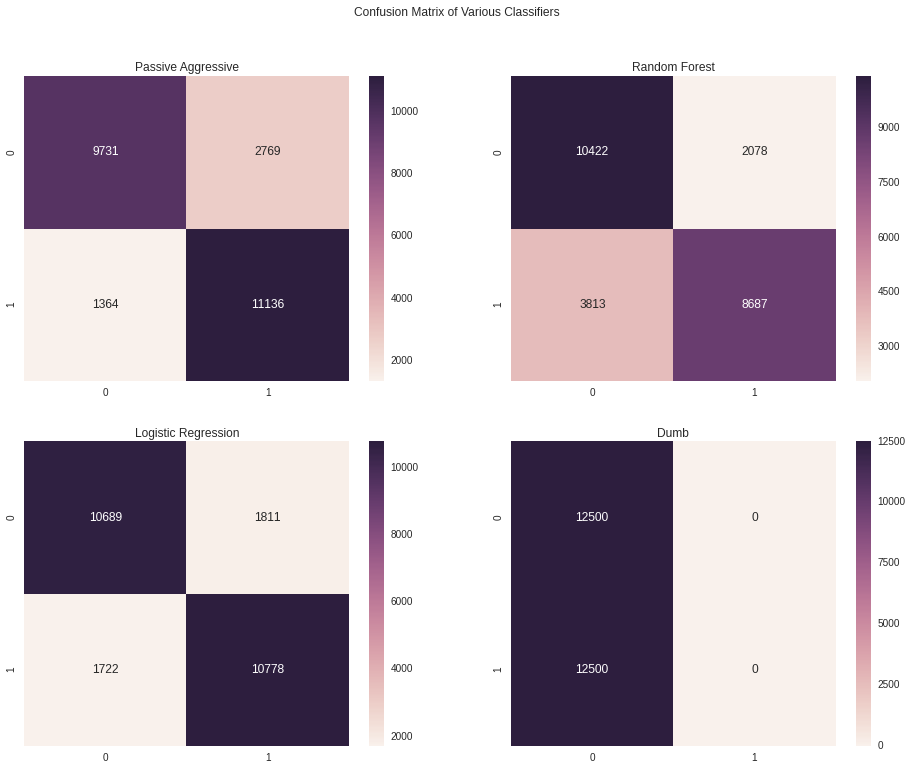

In [35]:
def draw_conf_matrix(pa_conf_mat,rf_conf_mat,lr_conf_mat,dumb_conf_mat):
  conf_matrix = {
                1: {
                    'matrix': pa_conf_mat,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': rf_conf_mat,
                    'title': 'Random Forest',
                   },
                3: {
                    'matrix': lr_conf_mat,
                    'title': 'Logistic Regression',
                   },
                4: {
                    'matrix': dumb_conf_mat,
                    'title': 'Dumb',
                   },
  }
  fix, ax = plt.subplots(figsize=(16, 12))
  plt.suptitle('Confusion Matrix of Various Classifiers')
  for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(2, 2, ii) # starts from 1
    plt.title(title);
    seaborn.heatmap(matrix, annot=True,  fmt='');
draw_conf_matrix(pa_conf_matrix,rf_conf_matrix,lr_conf_matrix,dumb_conf_matrix)

In [25]:
bpa_class,brf_class,blr_class = print_fastscores(bi_features,train["sentiment"])

Passive Aggressive Classifier: 0.54
Random Forest Classifier:      0.58
Logistic Regression:           0.61
Dump Classifier: 0.50


In [26]:
tpa_class,trf_class,tlr_class = print_fastscores(tri_features,train["sentiment"])

Passive Aggressive Classifier: 0.52
Random Forest Classifier:      0.53
Logistic Regression:           0.55
Dump Classifier: 0.50


In [53]:
small_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 500) 
train_small_features = small_vectorizer.fit_transform(kag_list)
train_small_features = train_small_features.toarray()
print_slowscores(train_small_features,train["sentiment"])

K Nearest Neighbor Classifier: 0.65
Gradient Boosting Classifier:  0.81
Support vector machine(SVM):   0.84


In [54]:
spa_class,srf_class,slr_class = print_fastscores(train_small_features,train["sentiment"])

Passive Aggressive Classifier: 0.78
Random Forest Classifier:      0.75
Logistic Regression:           0.84
Dump Classifier: 0.50


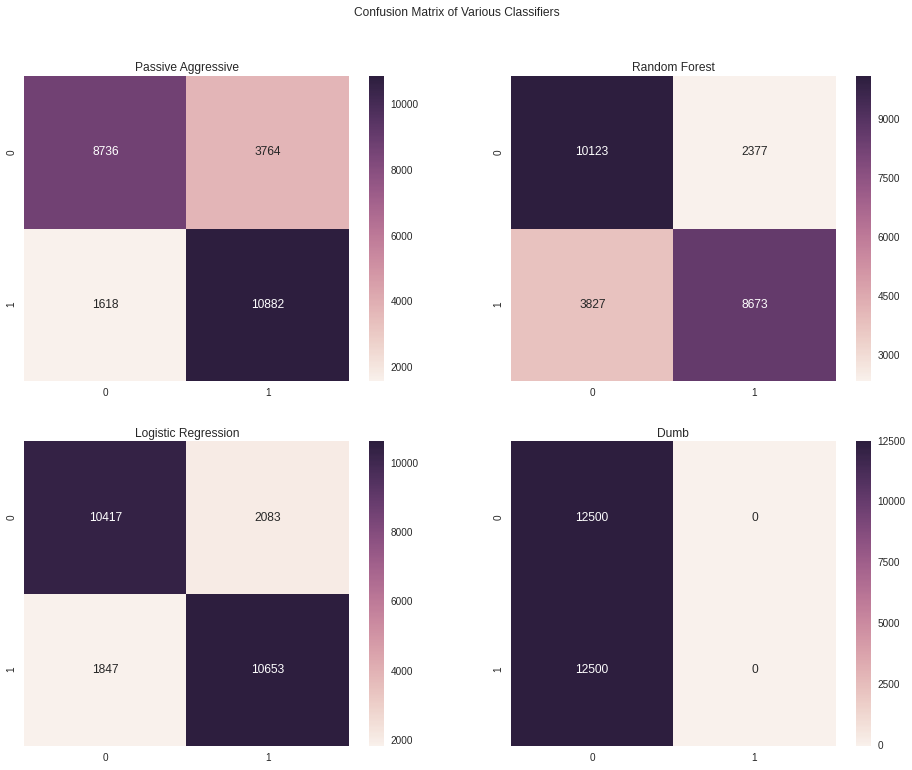

In [50]:
spa_conf_matrix,srf_conf_matrix,slr_conf_matrix,sdumb_conf_matrix = fast_confusion_matrices(train["sentiment"], 
                                                                         spa_class,srf_class,slr_class)
draw_conf_matrix(spa_conf_matrix,srf_conf_matrix,slr_conf_matrix,sdumb_conf_matrix)